# NORMALIZING FLOWS

Normalizing flows are a great tool for modeling complicated PDFs. They work by applying a chain of **invertible** transformations to a base distribution (often a Normal distribution) until the target PDF is reproduced.

There are several different types of Flows depending on how the transformations are constructed. In this case, we are going to build and train a **Masked Autorregressive Flow** (MAF).

In tensorflow, we construct these transformations by using **bijectors**, which can be imported from the tensorflow-probability package.

Here's an illustration of the transformation process using a MAF model made of 5 transformations trained to learn the s_curve distribution from sklearn.datasets

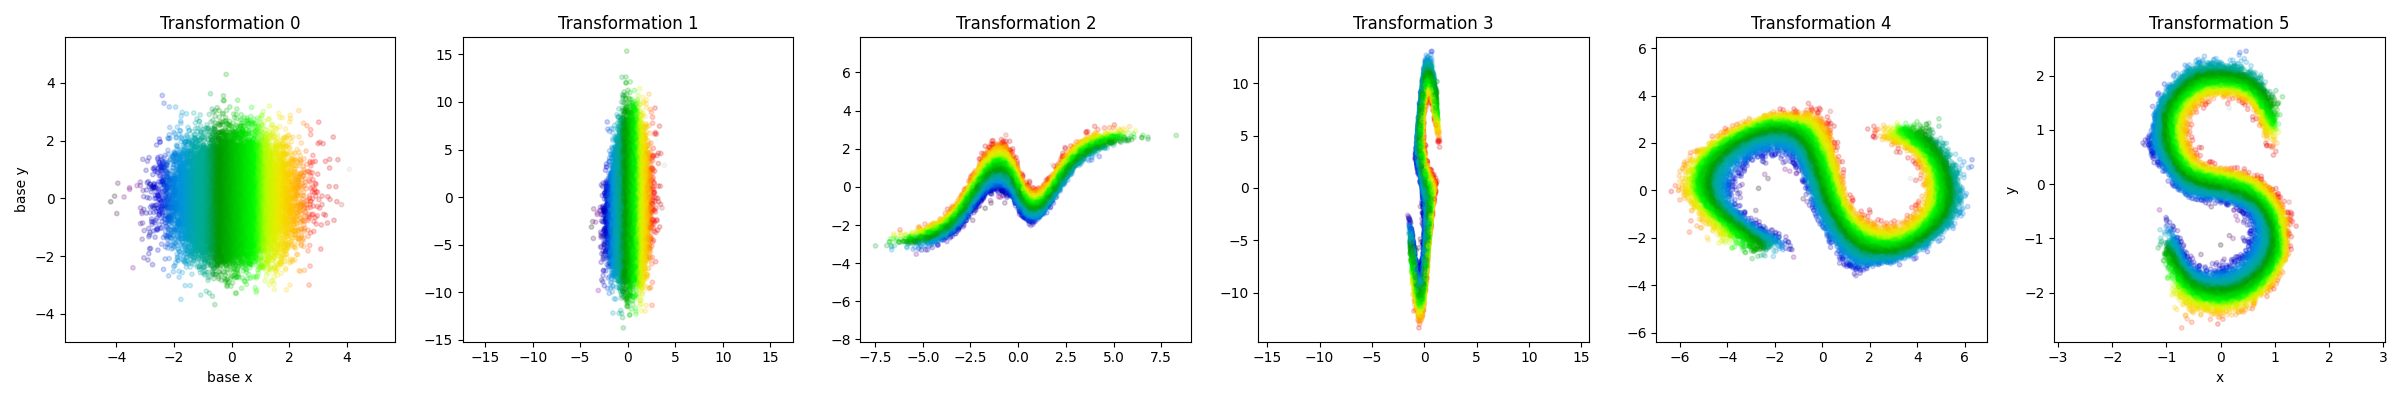

We can go one step beyond this, building a **conditional** flow model. This allows transformations to be learnt in different ways depending on input conditions. For example, we can create a dataset with points from the s-curve, but then add different 2-d shifts to each point. Then we can use these displacements as conditions, so we are conditioning the model on the "centroid" of the s_curve distribution we want to recover. Take a look at the transformation process of the same model for 2 different centroids pass as conditions.

Transformation for centroid [1,1]

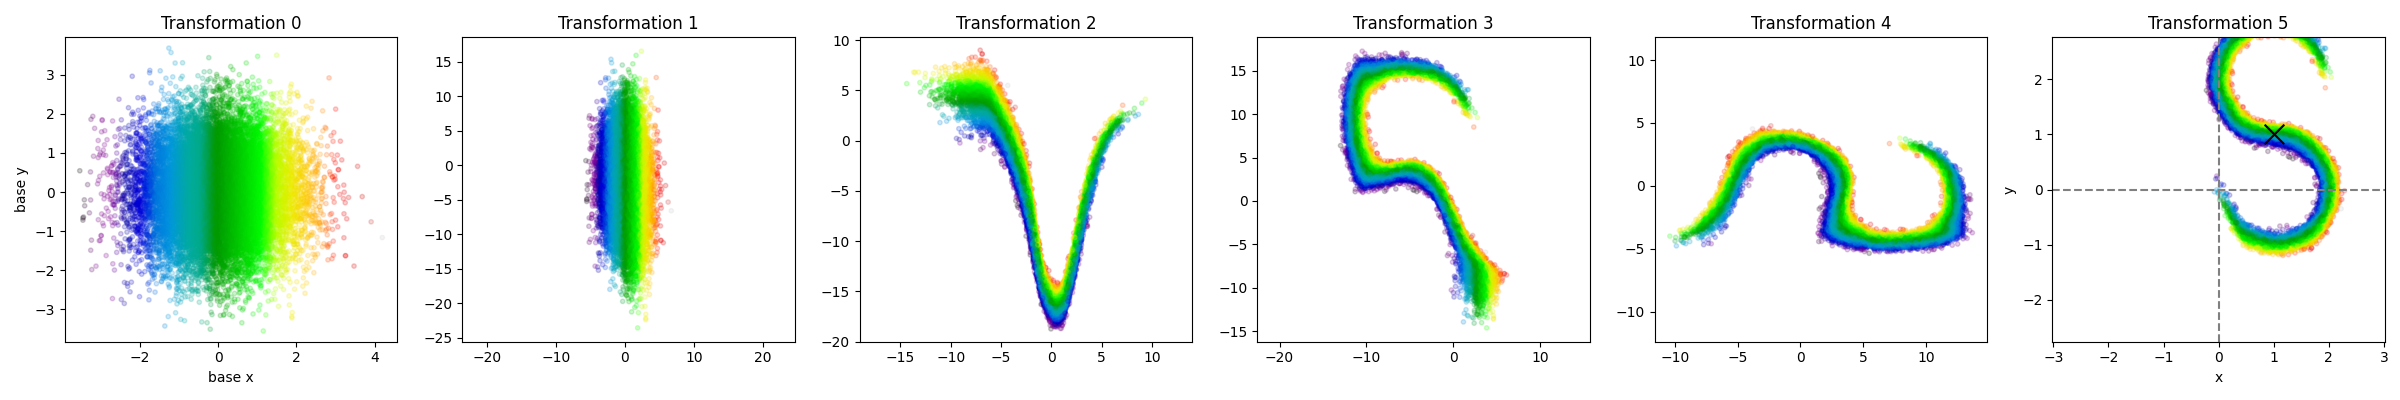

Transformation for centroid [-1,-1]

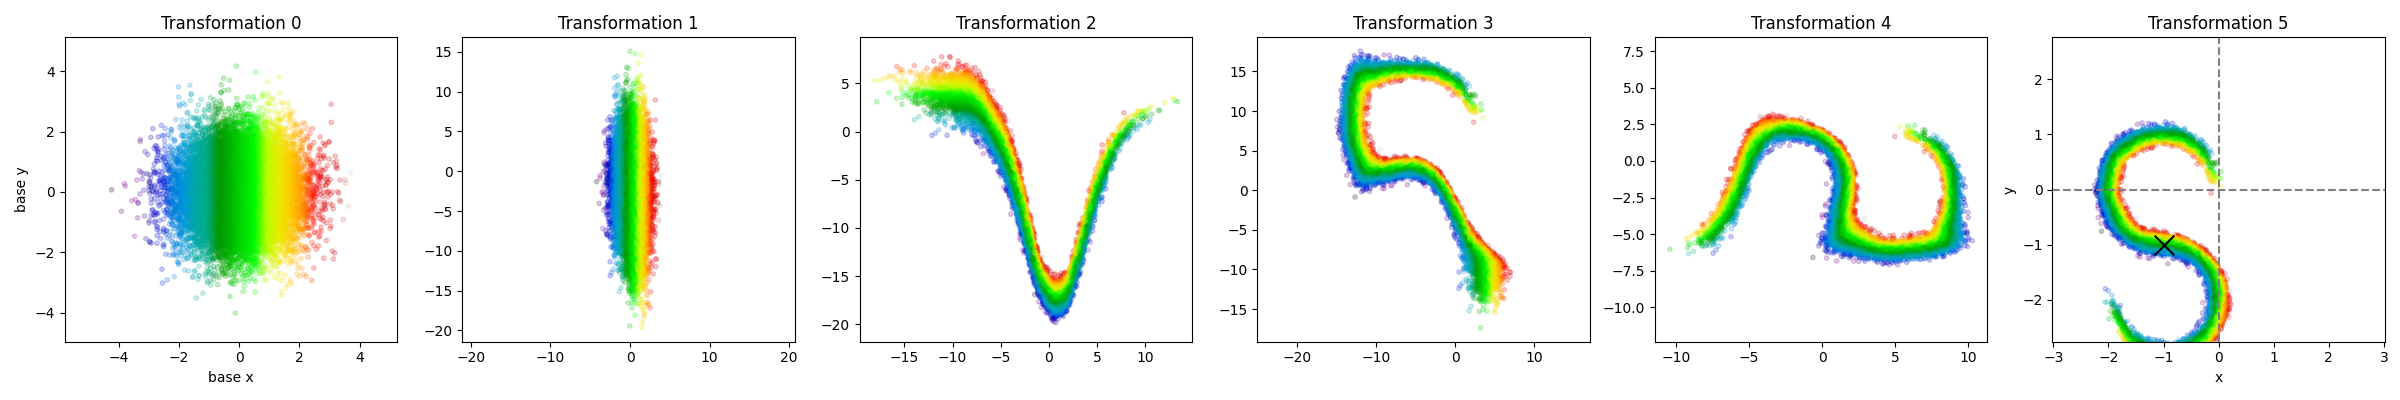

In this notebook we want to obtain a different PDF for the target variables (astrometric errors) of each element in the dataset (each star), so the transformations need to be different depending on some conditions (the same stellar features we have been using as inputs). So what we need is a **conditional MAF** model.

In [ ]:
!pip install pygaia astroquery corner

In [ ]:
import time
import re

from astropy.table import Table
import pandas as pd

import numpy as np
import random
from scipy import stats

import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras as tfk # WARNING: this is keras 2, which is needed for tfp 0.25.0. Using tf.keras with tf 2.16+ will give you keras 3 and lead to errors when combined with some tfp functionalities.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import corner

tfkl = tfk.layers
tfd = tfp.distributions
tfb = tfp.bijectors

2025-09-17 13:36:07.909304: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 13:36:09.221553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-17 13:36:13.957160: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tfk.utils.set_random_seed(seed)

## 1. Creating the model

In [ ]:
#Helper function to pass conditions to our Flow blocks
def make_bijector_kwargs(bijector, name_to_kwargs):
  if hasattr(bijector, 'bijectors'): # chain of bijectors
    return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
  else:
    for name_regex, kwargs in name_to_kwargs.items():
      if re.match(name_regex, bijector.name):
        return kwargs
  return {}

**SHORT EXPLANATION ON THE LAYERS**

Here, tfb.MaskedAutoregressiveFlow is one of our transformations (flows), and tfb.AutoregressiveNetwork handles the neural network that takes our inputs and provides tfb.MaskedAutoregressiveFlow the parameters it needs to perform the transformation.

In a MAF, the nomenclature for our layers is **Masked Autorregressive Density Estimators (MADE)**.

Between each flow block we are adding **permutations**. The MAF algorithm uses information from the previous dimensions to transform a given dimension. If we don't add permutations, the transformations applied to the first dimension never include information from the other dimensions. Addind these permutations augment the expressive power of our MAF model.

In [ ]:
#Let's create our MAF model

def create_conditional_maf(input_shape, conditional_input_shape, num_flows, hidden_units):
  #num_flows: The number of flow blocks (number of chained transformations)
  #hidden_units:  A list of integers. This specifies how many trainable neurons form each layer
  #               of our autorregressive networks (this is what learns the necessary transformation)

  bijectors = []

  for ii in range(num_flows):
    made = tfb.AutoregressiveNetwork(
    params=2, # return 2 parameters: loc and scale, that's what we need to create transformations
    hidden_units=hidden_units,
    activation='sigmoid',
    event_shape=(input_shape,),
    conditional=True,
    conditional_event_shape=(conditional_input_shape,)
    )

    flow = tfb.MaskedAutoregressiveFlow(
    shift_and_log_scale_fn=made,
    name = 'made'+str(ii) # This is mandatory if we want to pass conditions to our bijectors
    )

    bijectors.append(flow)

    permutation = list(reversed(range(input_shape)))

    if ii < num_flows-1:
      bijectors.append(tfb.Permute(permutation=permutation))
    # When working with 2+ dimensions, permutations are needed to increase expressiveness.
    # This is beacuse in MAFs, each dimension is affected by the previous one. We don't
    # want all transformations to depend on the same first dimension.

  bijector_chain = tfb.Chain(list(reversed(bijectors))) # Our chain of transformations

  base_distribution = tfd.MultivariateNormalDiag(
      loc=tf.zeros(input_shape),
      scale_diag=tf.ones(input_shape)
  )
  distribution = tfd.TransformedDistribution(
  distribution=base_distribution,
  bijector=bijector_chain
  )

  x_ = tfkl.Input(shape=(input_shape,), dtype=tf.float32)

  c_ = tfkl.Input(shape=(conditional_input_shape,), dtype=tf.float32) # Now we also need conditions

  print('Take a look at our bijector kwargs. Always be careful with bijector naming.')
  bijector_kwargs = make_bijector_kwargs(bijector_chain, {'made.': {'conditional_input': c_}}) # We only apply conditions to MADE bijectors, permutations are not conditional
  print(bijector_kwargs)

  log_prob_ = distribution.log_prob(x_,
                                    bijector_kwargs = bijector_kwargs # This passes conditions to bijectors
                                    )

  model = tfk.Model([x_,c_], log_prob_)

  return model, distribution

**WHAT HAPPENS DURING TRAINING**

We have a series of transformations $f_{1}, f_{2}, ... f_{k}$ to transform our base distribution $p_{Z}(z)$ into the target distribution $P_{X}(x)$. Then:

$x = f(z)$, $z = f^{-1}(x)$

Since by construction f is invertible and differentiable, we can use the change of variable formula to compute the probability:

$p_{X}(x) = p_{Z}(z) \left| det\frac{\partial f^{-1}(x)}{\partial x} \right|$

With that, we calculate the negative log-likelihood, which we try to minimize during training.

In [ ]:
conditional_maf_model_astro, conditional_maf_distribution_astro = create_conditional_maf(input_shape = 3, conditional_input_shape = 5, num_flows = 3, hidden_units = [32,32])

conditional_maf_model_astro.compile(optimizer=tfk.optimizers.AdamW(learning_rate=5e-3),
              loss=lambda _, log_prob: -log_prob)

W0000 00:00:1758112588.031384 1321367 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Take a look at our bijector kwargs. Always be careful with bijector naming.
{'made2': {'conditional_input': <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'input_2')>}, 'permute': {}, 'made1': {'conditional_input': <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'input_2')>}, 'made0': {'conditional_input': <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'input_2')>}}


## 2. Reading the data

In [ ]:
data=Table.read("data.fits")

In [ ]:
input_parameters=["phot_g_mean_mag","phot_bp_mean_mag","phot_rp_mean_mag","astrometric_matched_transits","visibility_periods_used"]
output_parameters=["parallax_error","pmra_error","pmdec_error"]

# Create the inputs dataset
inputs=np.zeros((len(data),len(input_parameters)))
for i,param in enumerate(input_parameters):
    inputs[:,i]=data[param].data

# Create the outputs datasets
outputs=np.zeros((len(data),len(output_parameters)))
for i,param in enumerate(output_parameters):
    outputs[:,i]=np.log10(data[param].data)

In [ ]:
inputs_train, inputs_test, outputs_train, outputs_test,train,test = train_test_split(inputs, outputs, data.to_pandas(), test_size=0.2, random_state=seed)

In [ ]:
# For the input parameters
scaler_in = StandardScaler()
conditions_train = scaler_in.fit_transform(inputs_train) # Learn and apply the relation on the training set
conditions_test = scaler_in.transform(inputs_test) # Apply the trained relation on the test set

# For the output parameters
scaler_out = StandardScaler()
outputs_train = scaler_out.fit_transform(outputs_train)
outputs_test=scaler_out.transform(outputs_test)

## 3. Training the model

We are using a new **callback**: a **learning rate scheduler**. This will decrease our learning rate when the validation loss stops improving for a while, allowing the training to continue making smaller refinements.

Epoch 1/300
85/85 [==============================] - 3s 8ms/step - loss: 68244.4141 - val_loss: 221.7102 - lr: 0.0050
Epoch 2/300
85/85 [==============================] - 0s 3ms/step - loss: 209.6696 - val_loss: 138.2299 - lr: 0.0050
Epoch 3/300
85/85 [==============================] - 0s 3ms/step - loss: 115.1754 - val_loss: 74.4484 - lr: 0.0050
Epoch 4/300
85/85 [==============================] - 0s 3ms/step - loss: 75.0927 - val_loss: 56.3560 - lr: 0.0050
Epoch 5/300
85/85 [==============================] - 0s 3ms/step - loss: 58.5993 - val_loss: 46.0834 - lr: 0.0050
Epoch 6/300
85/85 [==============================] - 0s 3ms/step - loss: 48.9606 - val_loss: 38.8052 - lr: 0.0050
Epoch 7/300
85/85 [==============================] - 0s 3ms/step - loss: 42.1327 - val_loss: 33.7978 - lr: 0.0050
Epoch 8/300
85/85 [==============================] - 0s 3ms/step - loss: 37.2537 - val_loss: 30.3192 - lr: 0.0050
Epoch 9/300
85/85 [==============================] - 0s 3ms/step - loss: 33.5526 

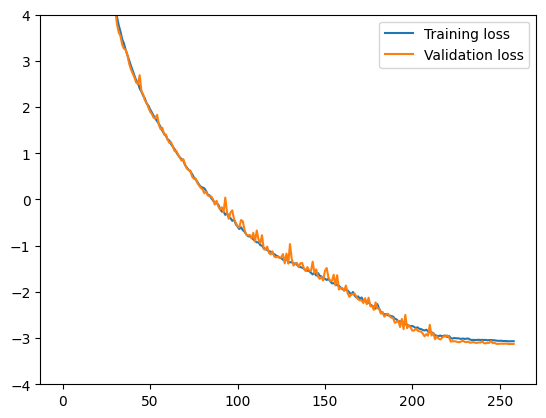

In [ ]:
callbacks = [
    tfk.callbacks.ReduceLROnPlateau(
        monitor="val_loss", # When the validation loss hasn't improved
        patience=5,         # for 5 epochs straight, we decrease the learning rate
        factor=0.5,         # by a factor of 0.5
        verbose=1,
        min_lr=1e-6
    ),
    tfk.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.01
    )
]

t1 = time.time()
history = conditional_maf_model_astro.fit(x=[outputs_train, conditions_train],
          y=np.zeros((len(outputs_train), 0), dtype=np.float32),
          validation_data=([outputs_test, conditions_test], np.zeros((len(outputs_test), 0), dtype=np.float32)),
          batch_size=128,
          epochs=300,
          shuffle=True,
          verbose=True,
          callbacks = callbacks) # We are aiming for a loss of ~ -3, expect 3-5 minutes of training
t2 = time.time()
print(f"Training time: {t2-t1} seconds")

plt.figure()
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.ylim([-4, 4])
plt.legend()
plt.show()

## 4. Drawing samples from the resulting posteriors

The sampling mechanic is really stright worfard, we just need to sample our base distribution $p_{Z}$ to get base samples z, and apply our composite transformation $f$ to obtain samples x of the target distribution $p_{X}$.

In the code below, all this is handled internally, we just call the sample funtion of our trained distribution, and we provide the conditions we want to apply to the bijectors.

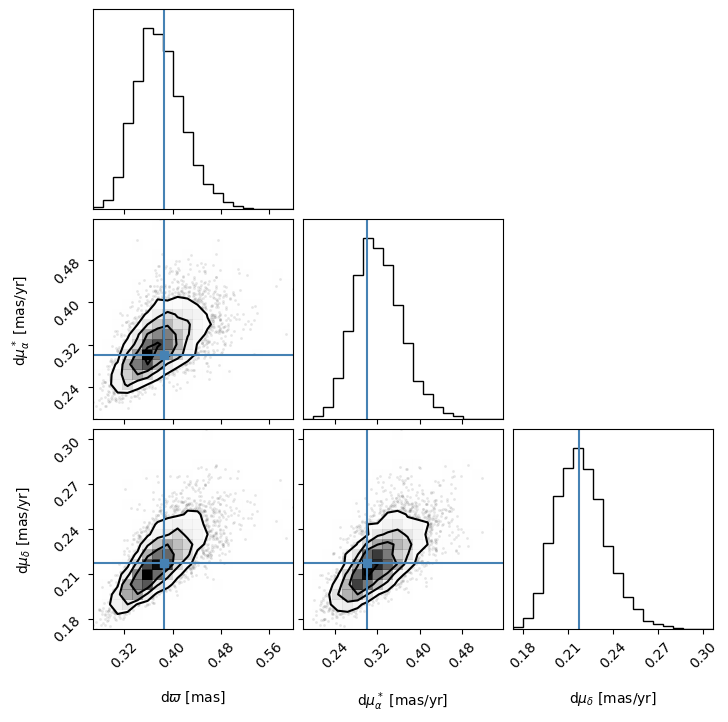

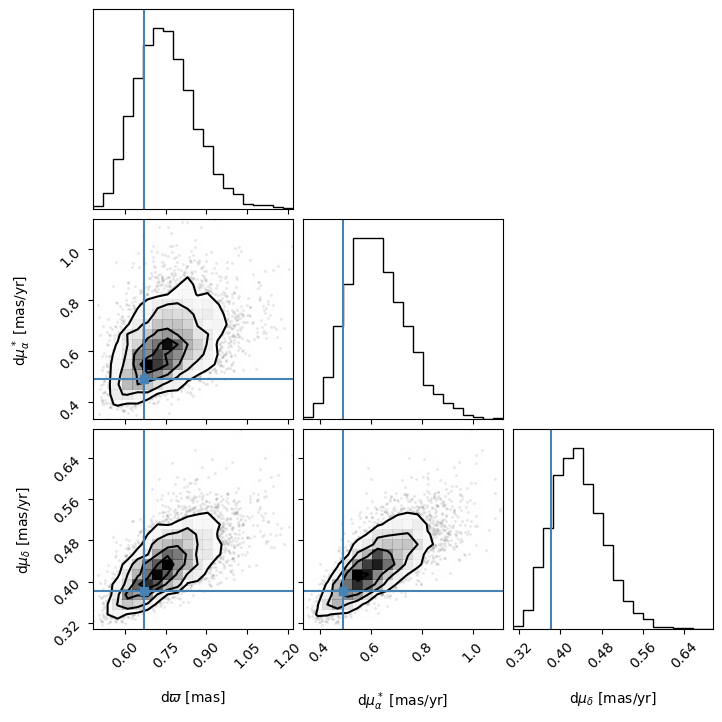

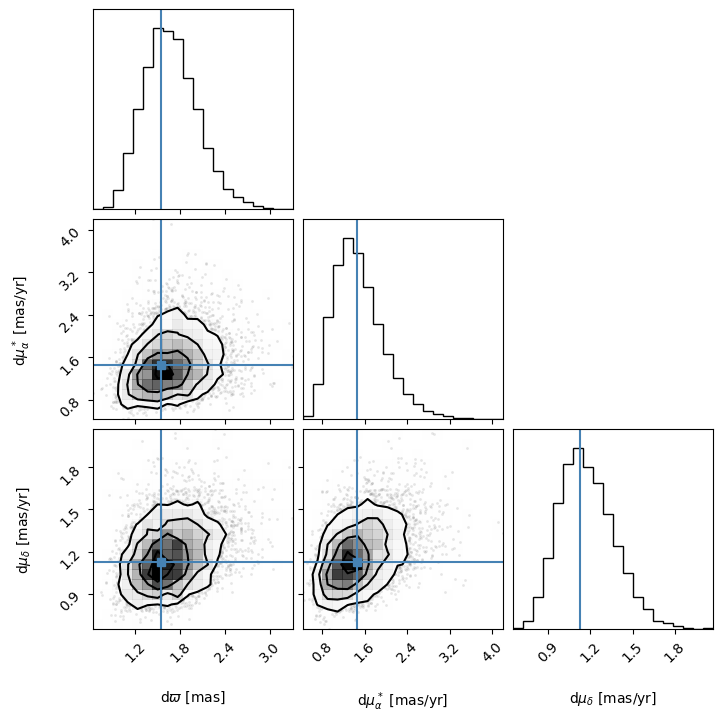

In [ ]:
dim_labels = [r"d$\varpi$", r"d$\mu_\alpha^*$", r"d$\mu_\delta$"]
dim_units  = ["[mas]", "[mas/yr]", "[mas/yr]"]

outputs_test_descaled = scaler_out.inverse_transform(outputs_test)

# Look at the confidence levels drawing PDF samples for a couple of validation elements
for ii in range(3):

  test_index = np.random.randint(0, outputs_test.shape[0])

  n_samples = 5000

  cond = conditions_test[test_index] * np.ones((n_samples, 1)) # Condition for each sample we want to draw

  # Create the dictionary to pass conditions to each bijector
  bijector_kwargs_cond = make_bijector_kwargs(conditional_maf_distribution_astro.bijector, {'made.': {'conditional_input': cond}})

  samples = conditional_maf_distribution_astro.sample(
  (n_samples,), # This is the total number of samples you want, same length as the conditions passed
  bijector_kwargs=bijector_kwargs_cond
  ).numpy()

  samples = 10**scaler_out.inverse_transform(samples)

  fig = corner.corner(
      samples,
      labels=[lab + " " + unit for lab, unit in zip(dim_labels, dim_units)],
      truths=10**outputs_test_descaled[test_index],
  )
  plt.show()

So the PDFs look pretty correct. In this case they don't seem so different from multivariate normal distributions (with covariances and sometimes skewness), but remember flows are able to recover very complex posteriors if necessary.

#### **EXERCISE**

Now let's draw some samples for all validation elements. **Can you do it without using a loop?** This makes sampling significantly faster.

In [ ]:
# Version for students to code

# Let's draw 100 samples for each element of the validation dataset

n_samples = 100

conditions = # An array with the conditions (repeated n_samples times) for each element

bijector_kwargs_cond = # Create the condition dictionary

samples_all_test = # Draw the samples

samples_all_test = # Samples are scaled, revert the scaling
samples_all_test = # Now reshape everything to (N_val_elements, N_samples, N_dimensions)

SyntaxError: invalid syntax (ipython-input-2728637614.py, line 7)

###### SOLUTION

In [ ]:
###SOLUTION###
n_samples = 100

conditions = np.repeat(conditions_test, n_samples, axis=0)

bijector_kwargs_cond = make_bijector_kwargs(conditional_maf_distribution_astro.bijector, {'made.': {'conditional_input': conditions}})

t3 = time.time()
samples_all_test = conditional_maf_distribution_astro.sample(
    (len(conditions),),
    bijector_kwargs=bijector_kwargs_cond
    ) # drawing all the samples (100 samples for each of the 2699 val elements) takes a few  seconds!!
t4 = time.time()
print(f"Sampling time: {t4-t3} seconds")
samples_all_test = 10**scaler_out.inverse_transform(samples_all_test)
samples_all_test = samples_all_test.reshape((outputs_test.shape[0], n_samples, outputs_test.shape[1]))

Sampling time: 0.6216640472412109 seconds


######

Better than checking each PDF visually: Let's check how often the true value lies within each confidence level. We should find the true value within the 0.68 confidence interval (1-sigma) in 68% of the cases, and so on.  

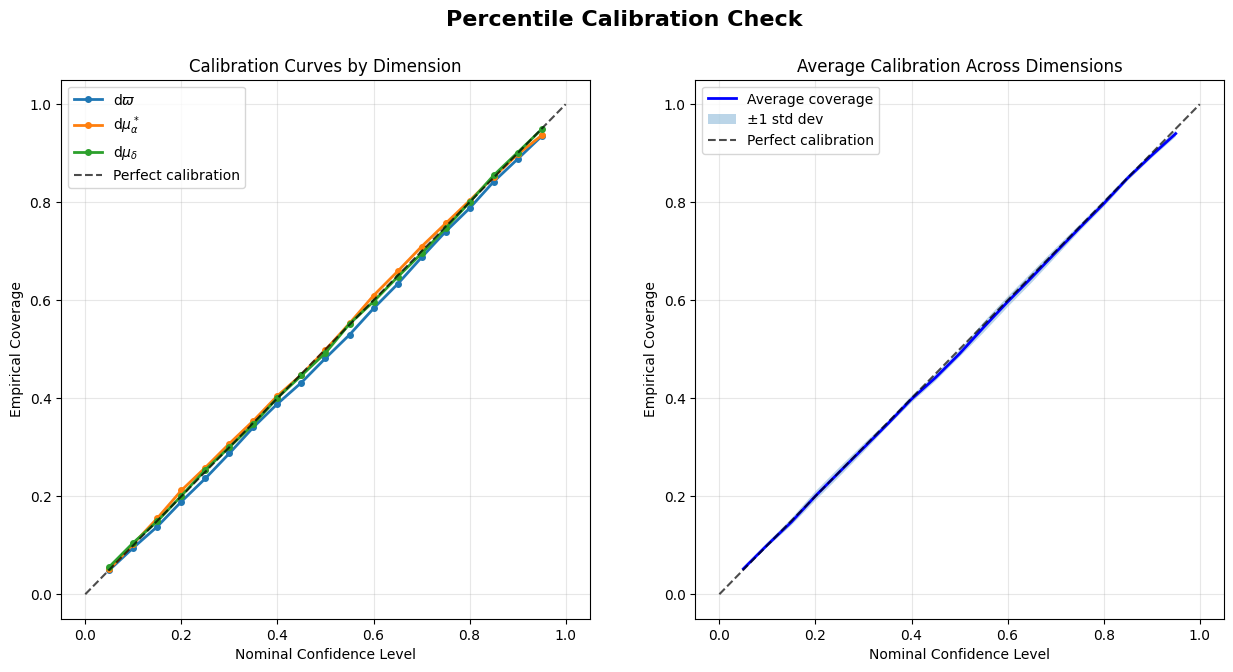

In [ ]:
def check_coverage(true_values, samples, confidence_levels=None):

    if confidence_levels is None:
        confidence_levels = np.arange(0.05, 1.0, 0.05)

    N_data, N_samples, N_dimensions = samples.shape
    n_levels = len(confidence_levels)

    empirical_coverage = np.zeros((N_dimensions, n_levels))

    for dim in range(N_dimensions):
        for i, alpha in enumerate(confidence_levels):
            lower_percentile = (1 - alpha) / 2 * 100
            upper_percentile = (1 - (1 - alpha) / 2) * 100

            lower_bounds = np.percentile(samples[:, :, dim], lower_percentile, axis=1)
            upper_bounds = np.percentile(samples[:, :, dim], upper_percentile, axis=1)

            coverage = np.mean((true_values[:, dim] >= lower_bounds) &
                              (true_values[:, dim] <= upper_bounds))

            empirical_coverage[dim, i] = coverage

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle('Percentile Calibration Check', fontsize=16, fontweight='bold')

    for dim in range(N_dimensions):
        axes[0].plot(confidence_levels, empirical_coverage[dim],
                       marker='o', linestyle='-', linewidth=2, markersize=4,
                       label=dim_labels[dim])

    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Perfect calibration')
    axes[0].set_xlabel('Nominal Confidence Level')
    axes[0].set_ylabel('Empirical Coverage')
    axes[0].set_title('Calibration Curves by Dimension')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    avg_coverage = np.mean(empirical_coverage, axis=0)
    std_coverage = np.std(empirical_coverage, axis=0)

    axes[1].plot(confidence_levels, avg_coverage, 'b-', linewidth=2, label='Average coverage')
    axes[1].fill_between(confidence_levels,
                           avg_coverage - std_coverage,
                           avg_coverage + std_coverage,
                           alpha=0.3, label='±1 std dev')
    axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Perfect calibration')
    axes[1].set_xlabel('Nominal Confidence Level')
    axes[1].set_ylabel('Empirical Coverage')
    axes[1].set_title('Average Calibration Across Dimensions')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)


    return


outputs_test_descaled=scaler_out.inverse_transform(outputs_test)
check_coverage(10**outputs_test_descaled, samples_all_test)
plt.show()

Looks like our posterior calibration is nearly perfect :)

In [ ]:
# Sample for the training set too

n_samples = 100

conditions = np.repeat(conditions_train, n_samples, axis=0)

bijector_kwargs_cond = make_bijector_kwargs(conditional_maf_distribution_astro.bijector, {'made.': {'conditional_input': conditions}})

t5 = time.time()
samples_all_train = conditional_maf_distribution_astro.sample(
    (len(conditions),),
    bijector_kwargs=bijector_kwargs_cond
    )
t6 = time.time()
print(f"Sampling time: {t4-t3} seconds")
samples_all_train = 10**scaler_out.inverse_transform(samples_all_train)
samples_all_train = samples_all_train.reshape((outputs_train.shape[0], n_samples, outputs_train.shape[1]))

Sampling time: 0.6216640472412109 seconds


## 5. Providing predicted values with uncertainties

Finally of course, we can get our prediction most probable value for the astrometric errors by taking the median of the samples. We assign uncertainties using percentiles (68% for 1-sigma).

In [ ]:
# Get medians and 1-sigma uncertainties
medians_train = np.median(samples_all_train, axis=1)
medians_test = np.median(samples_all_test, axis=1)

p_16_train = np.percentile(samples_all_train, 16, axis=1)
p_84_train = np.percentile(samples_all_train, 84, axis=1)

p_16_test = np.percentile(samples_all_test, 16, axis=1)
p_84_test = np.percentile(samples_all_test, 84, axis=1)

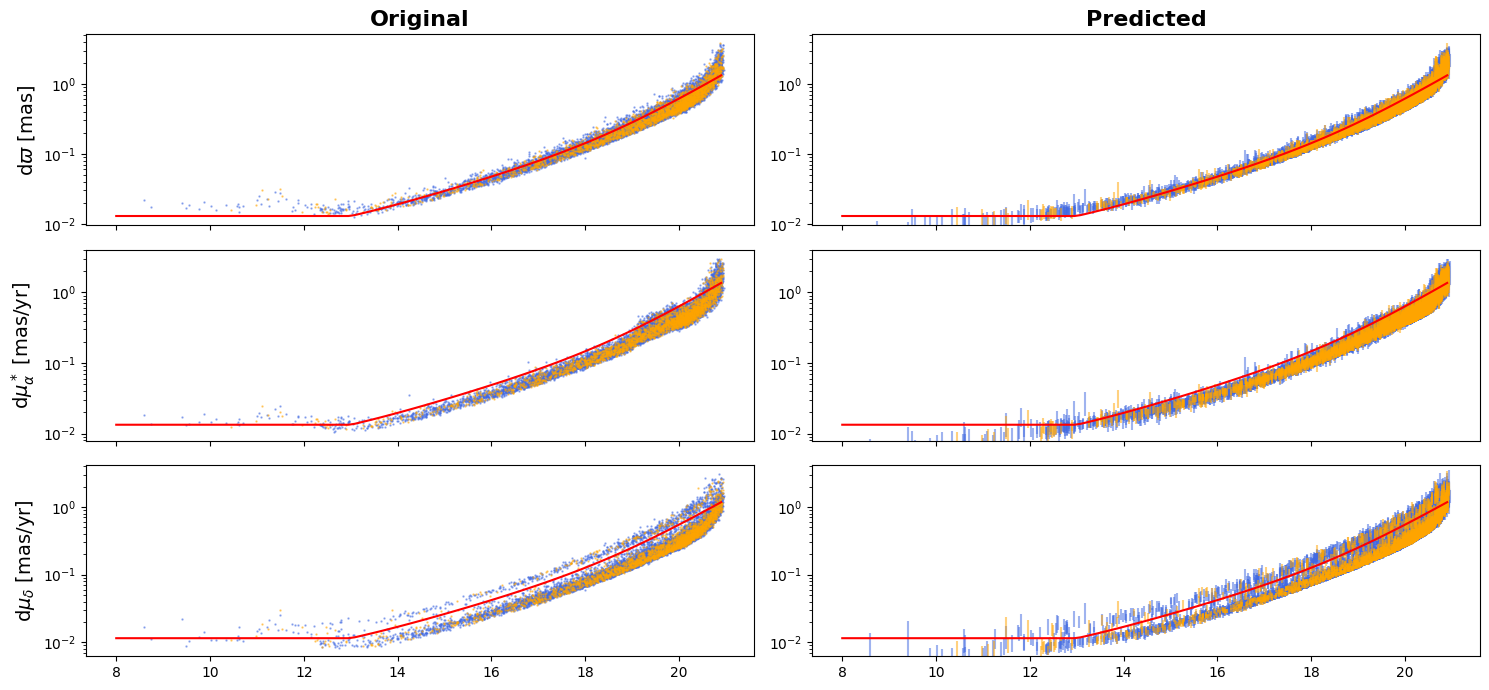

In [ ]:
import pygaia
from pygaia.errors.astrometric import parallax_uncertainty, proper_motion_uncertainty

# Plot the real and predicted values for the training and test sets
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 7), sharex=True)

x = np.linspace(8, 20.9, 100)

# Parallax
ax1.scatter(train["phot_g_mean_mag"], train["parallax_error"], s=0.5, alpha=0.5, c="royalblue", rasterized=True)
ax1.scatter(test["phot_g_mean_mag"], test["parallax_error"], s=0.5, alpha=0.5, c="orange", rasterized=True)
ax2.errorbar(train["phot_g_mean_mag"], medians_train[:,0], yerr = np.vstack([medians_train[:,0]-p_16_train[:,0], p_84_train[:,0]-medians_train[:,0]]), ms=0.5, alpha=0.5, c="royalblue", rasterized=True, ls = 'None')
ax2.errorbar(test["phot_g_mean_mag"], medians_test[:,0], yerr = np.vstack([medians_test[:,0]-p_16_test[:,0], p_84_test[:,0]-medians_test[:,0]]), ms=0.5, alpha=0.5, c="orange", rasterized=True, ls = 'None')
ax1.set_ylabel(r"d$\varpi$ [mas]", fontsize=14)
ax1.plot(x, parallax_uncertainty(x, release="dr3")/1000.0, "r-", rasterized=True)
ax2.plot(x, parallax_uncertainty(x, release="dr3")/1000.0, "r-", rasterized=True)
ax1.set_yscale("log")
ax2.set_yscale("log")

# pmra
ax3.scatter(train["phot_g_mean_mag"], train["pmra_error"], s=0.5, alpha=0.5, c="royalblue", rasterized=True)
ax3.scatter(test["phot_g_mean_mag"], test["pmra_error"], s=0.5, alpha=0.5, c="orange", rasterized=True)
ax4.errorbar(train["phot_g_mean_mag"], medians_train[:,1], yerr = np.vstack([medians_train[:,1]-p_16_train[:,1], p_84_train[:,1]-medians_train[:,1]]), ms=0.5, alpha=0.5, c="royalblue", rasterized=True, ls = 'None')
ax4.errorbar(test["phot_g_mean_mag"], medians_test[:,1], yerr = np.vstack([medians_test[:,1]-p_16_test[:,1], p_84_test[:,1]-medians_test[:,1]]), ms=0.5, alpha=0.5, c="orange", rasterized=True, ls = 'None')
ax3.plot(x, proper_motion_uncertainty(x, release="dr3")[0]/1000.0, "r-", rasterized=True)
ax4.plot(x, proper_motion_uncertainty(x, release="dr3")[0]/1000.0, "r-", rasterized=True)
ax3.set_yscale("log")
ax3.set_ylabel(r"d$\mu_\alpha^*$ [mas/yr]", fontsize=14)
ax4.set_yscale("log")

# pmdec
ax5.scatter(train["phot_g_mean_mag"], train["pmdec_error"], s=0.5, alpha=0.5, c="royalblue", rasterized=True)
ax5.scatter(test["phot_g_mean_mag"], test["pmdec_error"], s=0.5, alpha=0.5, c="orange", rasterized=True)
ax6.errorbar(train["phot_g_mean_mag"], medians_train[:,2], yerr = np.vstack([medians_train[:,2]-p_16_train[:,2], p_84_train[:,2]-medians_train[:,2]]), ms=0.5, alpha=0.5, c="royalblue", rasterized=True, ls = 'None')
ax6.errorbar(test["phot_g_mean_mag"], medians_test[:,2], yerr = np.vstack([medians_test[:,2]-p_16_test[:,2], p_84_test[:,2]-medians_test[:,2]]), ms=0.5, alpha=0.5, c="orange", rasterized=True, ls = 'None')
ax5.plot(x, proper_motion_uncertainty(x, release="dr3")[1]/1000.0, "r-", rasterized=True)
ax6.plot(x, proper_motion_uncertainty(x, release="dr3")[1]/1000.0, "r-", rasterized=True)
ax5.set_yscale("log")
ax5.set_ylabel(r"d$\mu_\delta$ [mas/yr]", fontsize=14)
ax6.set_yscale("log")

# Définir les mêmes limites pour les sous-graphiques de chaque ligne
for ax_pair in [(ax1, ax2), (ax3, ax4), (ax5, ax6)]:
    y_lims = ax_pair[0].get_ylim()
    for ax in ax_pair:
        ax.set_ylim(y_lims)

ax1.set_title("Original", fontweight="bold", fontsize=16)
ax2.set_title("Predicted", fontweight="bold", fontsize=16)

fig.tight_layout()
plt.show()

Our predictions are much better than the simple model provided by  Gaia (red line)